<a href="https://colab.research.google.com/github/aldiekawahyu/manajerku-inventory-management/blob/main/demand_forecasting_newdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data
Source: https://www.kaggle.com/c/demand-forecasting-kernels-only/data \\
Steps:
1. Go to kaggle account and click **'Create New API Token'**. A kaggle.json file will be downloaded to your local machine.
1. Upload the kaggle.json file into into colab
1. Download the dataset from kaggle and unzip it

In [ ]:
import os

! pip install -q kaggle
from google.colab import files
files.upload()
try:
  os.makedirs('~/.kaggle')    
  print('Directory created successfully')
except:
  pass
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c demand-forecasting-kernels-only
! unzip train.csv.zip

Saving kaggle.json to kaggle.json
  0% 0.00/385k [00:00<?, ?B/s]
100% 385k/385k [00:00<00:00, 58.0MB/s]
  0% 0.00/3.06M [00:00<?, ?B/s]
100% 3.06M/3.06M [00:00<00:00, 102MB/s]
  0% 0.00/952k [00:00<?, ?B/s]
100% 952k/952k [00:00<00:00, 129MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


# EDA and Data Preprocessing

## Check Missing Value and Object Type

First, open the csv file as pandas dataframe file then check if there are missing values.

In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('train.csv')
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Update: Only use store 1 with item 1-10

In [ ]:
df_train = df_train.loc[(df_train['store'] == 1) & (df_train['item'] <= 10)].drop('store', axis=1)
df_train.head()

,date,item,sales
0,2013-01-01,1,13
1,2013-01-02,1,11
2,2013-01-03,1,14
3,2013-01-04,1,13
4,2013-01-05,1,10


In [ ]:
df_test = pd.read_csv('test.csv')
df_test['sales'] = np.zeros(df_test.shape[0])
df_test.head()

,id,date,store,item,sales
0,0,2018-01-01,1,1,0.0
1,1,2018-01-02,1,1,0.0
2,2,2018-01-03,1,1,0.0
3,3,2018-01-04,1,1,0.0
4,4,2018-01-05,1,1,0.0


In [ ]:
df_test = df_test.loc[(df_test['store'] == 1) & (df_test['item'] <= 10)].drop(['store', 'id'], axis=1)
df_test.head()

,date,item,sales
0,2018-01-01,1,0.0
1,2018-01-02,1,0.0
2,2018-01-03,1,0.0
3,2018-01-04,1,0.0
4,2018-01-05,1,0.0


Join the dataframes

In [ ]:
df = pd.concat([df_train, df_test])
print('df length: {}'.format(len(df)))
df.head()


df length: 19160


,date,item,sales
0,2013-01-01,1,13.0
1,2013-01-02,1,11.0
2,2013-01-03,1,14.0
3,2013-01-04,1,13.0
4,2013-01-05,1,10.0


Check the number of missing value per column.

In [ ]:
df.isnull().sum()

date     0
item     0
sales    0
dtype: int64

Next, we will check the type of each column of the data.

In [ ]:
df.dtypes

date      object
item       int64
sales    float64
dtype: object

Altering the type of *date* column to datetime.

In [ ]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
item              int64
sales           float64
dtype: object

The *date* column is already converted to datetime.

## Get Unique Value of *item* and	*sales*

In [ ]:
items = sorted(df['item'].unique().tolist())
number_of_item = len(items)
print('Number of item: {}'.format(number_of_item))

Number of item: 10


## Check Total Dates (days) per item

In [ ]:
days_per_item = df.groupby(['item'])['date'].nunique()
print("Total number of days per item: \n{}".format(days_per_item.tolist()))

Total number of days per item: 
[1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916, 1916]


We can see that each product has the same amount of record.

## Inspect the Sales Aggregate of Each Item


In [ ]:
df.groupby(["item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
           sum       mean median        std
item                                       
1      36468.0  19.033403   19.0   7.821169
2      97050.0  50.652401   51.0  18.469260
3      60638.0  31.648225   32.0  12.086393
4      36440.0  19.018789   19.0   7.737107
5      30335.0  15.832463   16.0   6.559119
6      96889.0  50.568372   52.0  18.319247
7      96383.0  50.304280   51.0  18.475156
8     126856.0  66.208768   67.0  23.479411
9      84918.0  44.320459   45.0  16.251632
10    121163.0  63.237474   64.0  22.710425

## Pivot Table

In [ ]:
import numpy as np
df_pivot = pd.pivot_table(df, values=['sales'], index=['date'],
                    columns=['item'], aggfunc=np.sum).fillna(0)
df_pivot

sales                                                      
item          1     2     3     4     5     6     7     8     9     10
date                                                                  
2013-01-01  13.0  33.0  15.0  10.0  11.0  31.0  25.0  33.0  18.0  37.0
2013-01-02  11.0  43.0  30.0  11.0   6.0  36.0  23.0  37.0  23.0  34.0
2013-01-03  14.0  23.0  14.0   8.0   8.0  18.0  34.0  38.0  25.0  32.0
2013-01-04  13.0  18.0  10.0  19.0   9.0  19.0  36.0  54.0  22.0  45.0
2013-01-05  10.0  34.0  23.0  12.0   8.0  31.0  38.0  51.0  29.0  35.0
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2018-03-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2018-03-28   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2018-03-29   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2018-03-30   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2018-03-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[1916 rows x 10 columns]

## **Feature Dataframe**

In [ ]:
df_pivot.columns

MultiIndex([('sales',  1),
            ('sales',  2),
            ('sales',  3),
            ('sales',  4),
            ('sales',  5),
            ('sales',  6),
            ('sales',  7),
            ('sales',  8),
            ('sales',  9),
            ('sales', 10)],
           names=[None, 'item'])

In [ ]:
df_feature = pd.DataFrame(index=df_pivot.index)
for colnames in df_pivot.columns:
  df_feature['item_{}_sales'.format(colnames[1])] = df_pivot[colnames[0], colnames[1]]
print(len(df_feature))

1916


In [ ]:
df_feature

,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales,item_10_sales
date,,,,,,,,,,
2013-01-01,13.0,33.0,15.0,10.0,11.0,31.0,25.0,33.0,18.0,37.0
2013-01-02,11.0,43.0,30.0,11.0,6.0,36.0,23.0,37.0,23.0,34.0
2013-01-03,14.0,23.0,14.0,8.0,8.0,18.0,34.0,38.0,25.0,32.0
2013-01-04,13.0,18.0,10.0,19.0,9.0,19.0,36.0,54.0,22.0,45.0
2013-01-05,10.0,34.0,23.0,12.0,8.0,31.0,38.0,51.0,29.0,35.0
...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are going to **fill missing dates** (if any) in *df_feature* with zero for every column.

In [ ]:
df_feature = df_feature.asfreq('D').fillna(0)
print(len(df_feature))

1916


Check the first and last day.

In [ ]:
from datetime import datetime, timedelta
first_date = df_feature.index.min()
last_date = df_feature.index.max()
print('First date: {}'.format(first_date))
print('Last date: {}'.format(last_date))

First date: 2013-01-01 00:00:00
Last date: 2018-03-31 00:00:00


Store the column names into list.

In [ ]:
item_list = df_feature.columns
item_list

Index(['item_1_sales', 'item_2_sales', 'item_3_sales', 'item_4_sales',
       'item_5_sales', 'item_6_sales', 'item_7_sales', 'item_8_sales',
       'item_9_sales', 'item_10_sales'],
      dtype='object')

## Time Series Plot

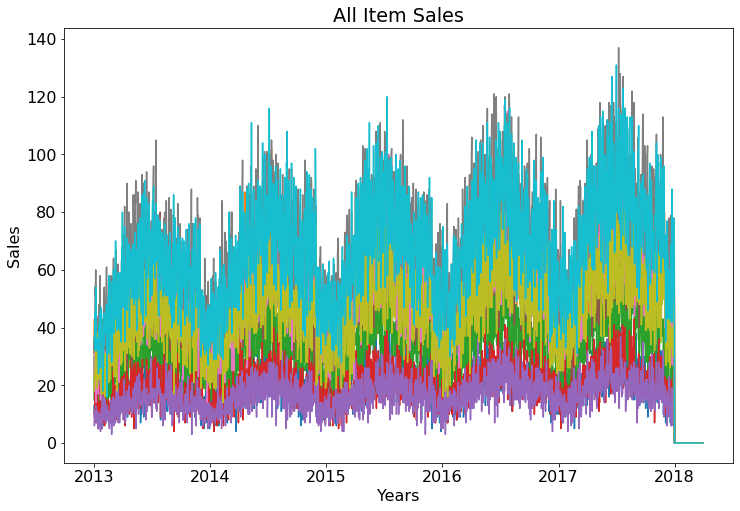

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(12,8))
for column in df_feature:
    plt.plot(df_feature.index, df_feature[column])
ax.set_title('All Item Sales')
ax.set_xlabel('Years')
ax.set_ylabel('Sales')
plt.show()

Randomly choose 10 series and plot them

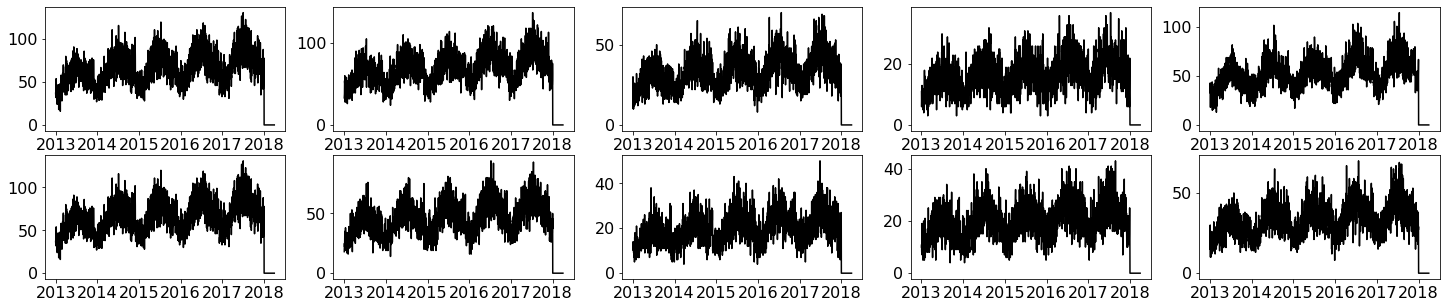

In [ ]:
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(25,5))
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].plot(df_feature.index, df_feature.sample(axis='columns').values, c='black')
plt.show()

Adding the *is_train* columns

In [ ]:
df_train_pivot = pd.pivot_table(df_train, values=['sales'], index=['date'],
                    columns=['item'], aggfunc=np.sum).fillna(0)
train_length = len(df_train_pivot)
print(train_length)

1826


In [ ]:
df_test_pivot = pd.pivot_table(df_test, values=['sales'], index=['date'],
                    columns=['item'], aggfunc=np.sum).fillna(0)
test_length = len(df_test_pivot)
print(test_length)

90


In [ ]:
boolean_list = [True] * train_length + [False] * test_length
df_feature['is_train'] = boolean_list

## One Hot Encoding for Time Units

In [ ]:
df_weekday = pd.get_dummies(df_feature.index.weekday, prefix='weekday')
df_weekday.index = df_feature.index
df_weekday.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,
2013-01-01,0,1,0,0,0,0,0
2013-01-02,0,0,1,0,0,0,0
2013-01-03,0,0,0,1,0,0,0
2013-01-04,0,0,0,0,1,0,0
2013-01-05,0,0,0,0,0,1,0


In [ ]:
df_month = pd.get_dummies(df_feature.index.month, prefix='month')
df_month.index =  df_feature.index
df_month.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_feature = pd.concat([df_weekday, df_month, df_feature], axis=1)
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Freq: D
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   weekday_0      1916 non-null   uint8  
 1   weekday_1      1916 non-null   uint8  
 2   weekday_2      1916 non-null   uint8  
 3   weekday_3      1916 non-null   uint8  
 4   weekday_4      1916 non-null   uint8  
 5   weekday_5      1916 non-null   uint8  
 6   weekday_6      1916 non-null   uint8  
 7   month_1        1916 non-null   uint8  
 8   month_2        1916 non-null   uint8  
 9   month_3        1916 non-null   uint8  
 10  month_4        1916 non-null   uint8  
 11  month_5        1916 non-null   uint8  
 12  month_6        1916 non-null   uint8  
 13  month_7        1916 non-null   uint8  
 14  month_8        1916 non-null   uint8  
 15  month_9        1916 non-null   uint8  
 16  month_10       1916 non-null   uint8  
 17  month_11       1916 non-nu

## Shift Demand

In [ ]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))

def shift_series_in_df(df, days_delta, series_names=[]):
    shifted = pd.DataFrame(index=df.index.copy())
    sign = 'future' if np.sign(days_delta) < 0 else 'past'
    for series_name in series_names:
        shifted['{}_{}_{}'.format(series_name,sign,np.abs(days_delta))] = \
          shift_series(df[series_name], days_delta)
    return shifted
    
def stack_shifted_sales(df, days_delta=90):
    names = item_list
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [ ]:
df_feature_shifted = stack_shifted_sales(df_feature, days_delta=-1)
df_feature_shifted = df_feature_shifted.dropna()

In [ ]:
df_feature_shifted

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales,item_10_sales,is_train,item_1_sales_past_1,item_2_sales_past_1,item_3_sales_past_1,item_4_sales_past_1,item_5_sales_past_1,item_6_sales_past_1,item_7_sales_past_1,item_8_sales_past_1,item_9_sales_past_1,item_10_sales_past_1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,11.0,43.0,30.0,11.0,6.0,36.0,23.0,37.0,23.0,34.0,True,13.0,33.0,15.0,10.0,11.0,31.0,25.0,33.0,18.0,37.0
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,14.0,23.0,14.0,8.0,8.0,18.0,34.0,38.0,25.0,32.0,True,11.0,43.0,30.0,11.0,6.0,36.0,23.0,37.0,23.0,34.0
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13.0,18.0,10.0,19.0,9.0,19.0,36.0,54.0,22.0,45.0,True,14.0,23.0,14.0,8.0,8.0,18.0,34.0,38.0,25.0,32.0
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,10.0,34.0,23.0,12.0,8.0,31.0,38.0,51.0,29.0,35.0,True,13.0,18.0,10.0,19.0,9.0,19.0,36.0,54.0,22.0,45.0
2013-01-06,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,12.0,38.0,23.0,16.0,13.0,31.0,32.0,60.0,35.0,54.0,True,10.0,34.0,23.0,12.0,8.0,31.0,38.0,51.0,29.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-28,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-29,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are going to make sure stacked and standard demand columns appear in the same order.

In [ ]:
sales_columns = [column for column in df_feature_shifted.columns if '_sales' in column and '_sales_' not in column]
stacked_sales_columns = [column for column in df_feature_shifted.columns if '_sales_' in column]
other_columns = [column for column in df_feature_shifted.columns if column not in set(sales_columns) and column not in set(stacked_sales_columns)]

sales_columns = sorted(sales_columns)
stacked_sales_columns = sorted(stacked_sales_columns)

new_columns = other_columns + stacked_sales_columns + sales_columns

In [ ]:
df_feature_shifted = df_feature_shifted.reindex(columns=new_columns)

In [ ]:
assert df_feature_shifted.isna().any().any() == False

In [ ]:
df_feature_shifted

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_train,item_10_sales_past_1,item_1_sales_past_1,item_2_sales_past_1,item_3_sales_past_1,item_4_sales_past_1,item_5_sales_past_1,item_6_sales_past_1,item_7_sales_past_1,item_8_sales_past_1,item_9_sales_past_1,item_10_sales,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,37.0,13.0,33.0,15.0,10.0,11.0,31.0,25.0,33.0,18.0,34.0,11.0,43.0,30.0,11.0,6.0,36.0,23.0,37.0,23.0
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,34.0,11.0,43.0,30.0,11.0,6.0,36.0,23.0,37.0,23.0,32.0,14.0,23.0,14.0,8.0,8.0,18.0,34.0,38.0,25.0
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,32.0,14.0,23.0,14.0,8.0,8.0,18.0,34.0,38.0,25.0,45.0,13.0,18.0,10.0,19.0,9.0,19.0,36.0,54.0,22.0
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,True,45.0,13.0,18.0,10.0,19.0,9.0,19.0,36.0,54.0,22.0,35.0,10.0,34.0,23.0,12.0,8.0,31.0,38.0,51.0,29.0
2013-01-06,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,True,35.0,10.0,34.0,23.0,12.0,8.0,31.0,38.0,51.0,29.0,54.0,12.0,38.0,23.0,16.0,13.0,31.0,32.0,60.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-28,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-29,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = [column for column in df_feature_shifted.columns if 'weekday' not in column and 'month' not in column]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_cols = scaler.fit_transform(df_feature_shifted[columns_to_scale])
df_feature_shifted[columns_to_scale] = scaled_cols
df_feature_shifted

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_train,item_10_sales_past_1,item_1_sales_past_1,item_2_sales_past_1,item_3_sales_past_1,item_4_sales_past_1,item_5_sales_past_1,item_6_sales_past_1,item_7_sales_past_1,item_8_sales_past_1,item_9_sales_past_1,item_10_sales,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.282443,0.26,0.286957,0.214286,0.232558,0.297297,0.298077,0.217391,0.240876,0.191489,0.259542,0.22,0.373913,0.428571,0.255814,0.162162,0.346154,0.200000,0.270073,0.244681
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.259542,0.22,0.373913,0.428571,0.255814,0.162162,0.346154,0.200000,0.270073,0.244681,0.244275,0.28,0.200000,0.200000,0.186047,0.216216,0.173077,0.295652,0.277372,0.265957
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.244275,0.28,0.200000,0.200000,0.186047,0.216216,0.173077,0.295652,0.277372,0.265957,0.343511,0.26,0.156522,0.142857,0.441860,0.243243,0.182692,0.313043,0.394161,0.234043
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.343511,0.26,0.156522,0.142857,0.441860,0.243243,0.182692,0.313043,0.394161,0.234043,0.267176,0.20,0.295652,0.328571,0.279070,0.216216,0.298077,0.330435,0.372263,0.308511
2013-01-06,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.267176,0.20,0.295652,0.328571,0.279070,0.216216,0.298077,0.330435,0.372263,0.308511,0.412214,0.24,0.330435,0.328571,0.372093,0.351351,0.298077,0.278261,0.437956,0.372340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-28,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-29,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# df_feature_shifted.to_csv('df_feature_shifted.csv')

## Get Training and Validation Dataframe

In [ ]:
df_train = df_feature_shifted[df_feature_shifted['is_train'] == True].drop('is_train', axis=1)
df_test = df_feature_shifted[df_feature_shifted['is_train'] == False].drop('is_train', axis=1)

Next we are going to extract the "X" and "y" for training

In [ ]:
X_columns_stacked = [column for column in df_train.columns if '_past_' in column]
X_columns_caldata = [column for column in df_train.columns if 'weekday' in column or 'month' in column]
X_columns = X_columns_stacked + X_columns_caldata

X = df_train[X_columns]

In [ ]:
X_colset = set(X_columns)
y_columns = [column for column in df_train.columns if column not in X_colset]

y = df_train[y_columns]

Train test split

In [ ]:
test_size = 0.2
training_size = 1 - test_size

X_train = X.iloc[:int(training_size*len(X))].copy()
X_valid = X.iloc[int(training_size*len(X)):].copy()
y_train = y.iloc[:int(training_size*len(y))].copy()
y_valid = y.iloc[int(training_size*len(y)):].copy()

Reshaping the variable for multivariate time series training.

In [ ]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Freq: D
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_10_sales_past_1  1825 non-null   float64
 1   item_1_sales_past_1   1825 non-null   float64
 2   item_2_sales_past_1   1825 non-null   float64
 3   item_3_sales_past_1   1825 non-null   float64
 4   item_4_sales_past_1   1825 non-null   float64
 5   item_5_sales_past_1   1825 non-null   float64
 6   item_6_sales_past_1   1825 non-null   float64
 7   item_7_sales_past_1   1825 non-null   float64
 8   item_8_sales_past_1   1825 non-null   float64
 9   item_9_sales_past_1   1825 non-null   float64
 10  weekday_0             1825 non-null   uint8  
 11  weekday_1             1825 non-null   uint8  
 12  weekday_2             1825 non-null   uint8  
 13  weekday_3             1825 non-null   uint8  
 14  weekday_4             1825 non-null   uint8  


In [ ]:
len(y.columns)

10

# Modeling and Forecasting

## Define the Model

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.__version__

'2.5.0'

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
    tf.keras.layers.LSTM(len(y.columns), return_sequences=True),
    tf.keras.layers.Dense(len(y.columns), activation='relu'),
    tf.keras.layers.Dense(len(y.columns)),
    tf.keras.layers.Conv1D(len(y.columns), kernel_size=1,
        input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])),
    tf.keras.layers.Conv1D(2*len(y.columns), kernel_size=50,
        padding='same', activation='relu'),
    # tf.keras.layers.Conv1D(len(y.columns), kernel_size=10,
    #     padding='same', activation='relu'),
    tf.keras.layers.AvgPool1D(pool_size=10, padding='same'),
    tf.keras.layers.LSTM(2*len(y.columns), dropout=0.2),
    tf.keras.layers.Dense(len(y.columns)),
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 10)             1600      
_________________________________________________________________
dense_24 (Dense)             (None, 1, 10)             110       
_________________________________________________________________
dense_25 (Dense)             (None, 1, 10)             110       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1, 10)             110       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 20)             10020     
_________________________________________________________________
average_pooling1d_8 (Average (None, 1, 20)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 20)               

In [ ]:
optimizer = tf.keras.optimizers.SGD()
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=["mape"])

## Training

In [ ]:
history = model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=300,
    batch_size=64,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False,    
)

Epoch 1/300
23/23 - 3s - loss: 0.0724 - mape: 17.0557 - val_loss: 0.0752 - val_mape: 14.5403
Epoch 2/300
23/23 - 0s - loss: 0.0736 - mape: 17.4572 - val_loss: 0.0741 - val_mape: 14.4359
Epoch 3/300
23/23 - 0s - loss: 0.0733 - mape: 17.5027 - val_loss: 0.0736 - val_mape: 14.3815
Epoch 4/300
23/23 - 0s - loss: 0.0728 - mape: 17.4551 - val_loss: 0.0737 - val_mape: 14.3907
Epoch 5/300
23/23 - 0s - loss: 0.0736 - mape: 17.6410 - val_loss: 0.0736 - val_mape: 14.3855
Epoch 6/300
23/23 - 0s - loss: 0.0733 - mape: 17.5596 - val_loss: 0.0741 - val_mape: 14.4369
Epoch 7/300
23/23 - 0s - loss: 0.0728 - mape: 17.3863 - val_loss: 0.0737 - val_mape: 14.3913
Epoch 8/300
23/23 - 0s - loss: 0.0737 - mape: 17.6318 - val_loss: 0.0734 - val_mape: 14.3673
Epoch 9/300
23/23 - 0s - loss: 0.0723 - mape: 17.3785 - val_loss: 0.0740 - val_mape: 14.4180
Epoch 10/300
23/23 - 0s - loss: 0.0729 - mape: 17.4819 - val_loss: 0.0734 - val_mape: 14.3688
Epoch 11/300
23/23 - 0s - loss: 0.0719 - mape: 17.2536 - val_loss: 0.

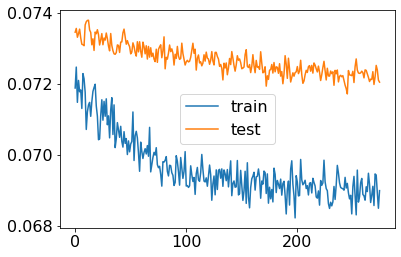

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'][25:], label='train')
plt.plot(history.history['val_loss'][25:], label='test')
plt.legend()
plt.show()

## Save the Model

In [ ]:
h5_model_file = 'model.h5'
model.save(h5_model_file)

In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_9'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1, 29)
      name: serving_default_input_9:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_26'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_9': TensorSpec(shape=(None, 1, 29), dtype=tf.float32, name='input_9')})
{'dense_26': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_26')}


## Conver Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Download the Converted Model

In [ ]:
! zip -r ./rps_saved_model.zip ./rps_saved_model/ 

  adding: rps_saved_model/ (stored 0%)
  adding: rps_saved_model/saved_model.pb (deflated 90%)
  adding: rps_saved_model/assets/ (stored 0%)
  adding: rps_saved_model/variables/ (stored 0%)
  adding: rps_saved_model/variables/variables.index (deflated 58%)
  adding: rps_saved_model/variables/variables.data-00000-of-00001 (deflated 14%)


In [ ]:
from google.colab import files
files.download(h5_model_file)
files.download(tflite_model_file)
files.download("rps_saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>